In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as mobilenet_preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import zipfile

In [3]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the UTKFace dataset from Kaggle
# (Replace the dataset identifier below with the appropriate one if needed)
!kaggle datasets download -d jangedoo/utkface-new


Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors


In [4]:
# Unzip the downloaded dataset (assumes the zip file is named 'utkface.zip')
!unzip -q utkface-new.zip -d utkface_data


In [5]:
img_height, img_width = 128,128
def load_utk_data(data_dir):
    images, ages = [], []
    for file in os.listdir(data_dir):
        if file.endswith('.jpg') or file.endswith('.png'):
            try:
                # Extract age from the filename (first element)
                age = int(file.split('_')[0])
                img_path = os.path.join(data_dir, file)
                img = load_img(img_path, target_size=(img_height, img_width))
                img = img_to_array(img)
                images.append(img)
                ages.append(age)
            except Exception as e:
                print(f"Skipping {file}: {e}")
    return np.array(images), np.array(ages)

data_dir = 'utkface_data/crop_part1'
X, y = load_utk_data(data_dir)


In [6]:
# Check that the number of images matches the number of labels
print("Total images loaded:", len(X))
print("Total age labels loaded:", len(y))

# Verify shapes if X is already a numpy array
print("X shape:", X.shape)

# Optionally, check a few age values
print("Unique age labels:", np.unique(y))


Total images loaded: 9780
Total age labels loaded: 9780
X shape: (9780, 128, 128, 3)
Unique age labels: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  95  96  99 100 101 110]


In [7]:
# Preprocess images: MobileNetV2 expects input in range [-1, 1]
X = mobilenet_preprocess_input(X)

# Split the dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [8]:

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7824, 128, 128, 3)
X_test shape: (1956, 128, 128, 3)
y_train shape: (7824,)
y_test shape: (1956,)


In [9]:
# Image dimensions
from tensorflow.keras import Sequential
# Image dimensions
img_height, img_width = 128, 128

# 1. Load MobileNetV2 without top layers
base_model = MobileNetV2(weights='imagenet', include_top=False,
                         input_shape=(img_height, img_width, 3))

# 2. Freeze the base model initially
for layer in base_model.layers:
    layer.trainable = False

# 3. Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.5),  # Moved dropout here
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Single output for regression
])

# 4. Compile the model with initial frozen layers
model.compile(optimizer=Adam(learning_rate=1e-3),  # Slightly higher LR for initial training
              loss='mean_squared_error',
              metrics=['mae'])
# Optional: View the model summary
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          81,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,342,081 (8.93 MB)

 Trainable params: 84,097 (328.50 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
# Train the model initially using X_train and y_train
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))




Epoch 1/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 134s 518ms/step - loss: 541.7338 - mae: 17.0958 - val_loss: 200.8029 - val_mae: 10.3181
Epoch 2/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 157s 580ms/step - loss: 210.0473 - mae: 10.4611 - val_loss: 207.2426 - val_mae: 10.1586
Epoch 3/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 210s 613ms/step - loss: 196.4223 - mae: 10.0496 - val_loss: 177.9350 - val_mae: 9.4476
Epoch 4/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 196s 587ms/step - loss: 180.1679 - mae: 9.5391 - val_loss: 173.1546 - val_mae: 9.2382
Epoch 5/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 194s 557ms/step - loss: 173.8955 - mae: 9.3410 - val_loss: 163.7416 - val_mae: 9.0186
Epoch 6/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 146s 573ms/step - loss: 179.8159 - mae: 9.5456 - val_loss: 168.1459 - val_mae: 9.1021
Epoch 7/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 138s 555ms/step - loss: 167.8956 - mae: 9.1886 - val_loss: 175.3090 - val_mae: 9.2522
Epoch 8/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 143s 559ms/step - loss: 160.1049 - mae: 8.9383 - val_loss: 195.8479 - val

In [11]:
fine_tune_at = len(base_model.layers) // 2  # Unfreeze the last half
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

# 6. Recompile with lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-4),  # Lower LR for fine-tuning
              loss='mean_squared_error',
              metrics=['mae'])



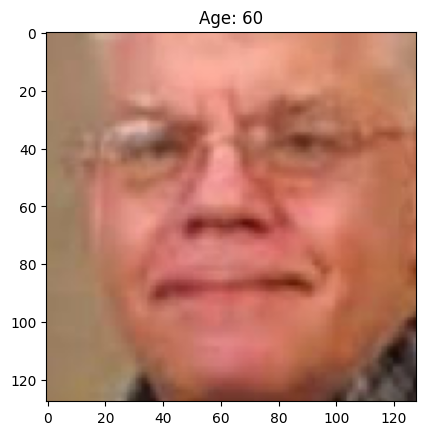

In [12]:
import matplotlib.pyplot as plt

plt.imshow((X_train[0] + 1) / 2)  # if using preprocess_input, adjust visualization accordingly
plt.title(f"Age: {y_train[0]}")
plt.show()


In [16]:

history_finetune = model.fit(X_train,y_train, epochs=5, validation_data=(X_test,y_test))


Epoch 1/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 236s 964ms/step - loss: 223.6106 - mae: 10.4366 - val_loss: 493.9487 - val_mae: 16.7443
Epoch 2/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 253s 928ms/step - loss: 117.4463 - mae: 7.6891 - val_loss: 405.3784 - val_mae: 15.1992
Epoch 3/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 267s 948ms/step - loss: 80.7756 - mae: 6.4299 - val_loss: 275.0266 - val_mae: 12.2229
Epoch 4/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 269s 978ms/step - loss: 75.2142 - mae: 6.0910 - val_loss: 305.2970 - val_mae: 12.7781
Epoch 5/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 254s 945ms/step - loss: 63.9122 - mae: 5.6241 - val_loss: 280.5949 - val_mae: 12.2666


In [17]:
# prompt: save model and weights

# Save the entire model
model.save('age_regression_model.h5')
model.save('age_regression_model.keras')

# Optionally, save only the model weights



In [21]:
model.save_weights('age_regressionn_weights.weights.h5')

In [18]:
# prompt: pickle ot save

import pickle

# Save the model using pickle
with open('age_regression_model.pkl', 'wb') as f:
    pickle.dump(model, f)



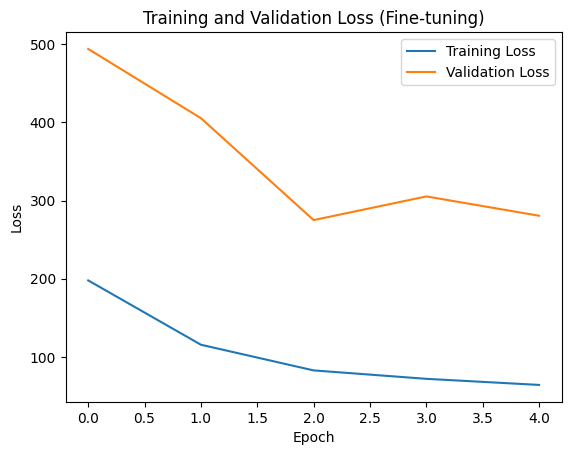

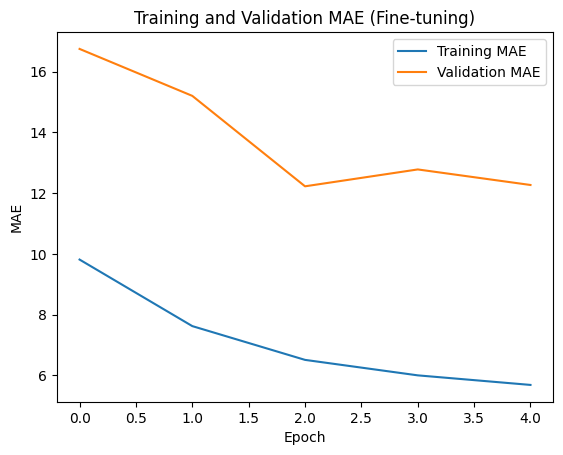

62/62 ━━━━━━━━━━━━━━━━━━━━ 24s 385ms/step - loss: 286.2386 - mae: 12.4484
Test Loss (Fine-tuning): 280.59490966796875
Test MAE (Fine-tuning): 12.26657485961914


In [19]:
# prompt: insights from history_finetune

import matplotlib.pyplot as plt
# Plot the training and validation loss
plt.plot(history_finetune.history['loss'], label='Training Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (Fine-tuning)')
plt.show()

# Plot the training and validation MAE
plt.plot(history_finetune.history['mae'], label='Training MAE')
plt.plot(history_finetune.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('Training and Validation MAE (Fine-tuning)')
plt.show()

# Evaluate the model after fine-tuning
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss (Fine-tuning): {loss}")
print(f"Test MAE (Fine-tuning): {mae}")


62/62 ━━━━━━━━━━━━━━━━━━━━ 30s 460ms/step


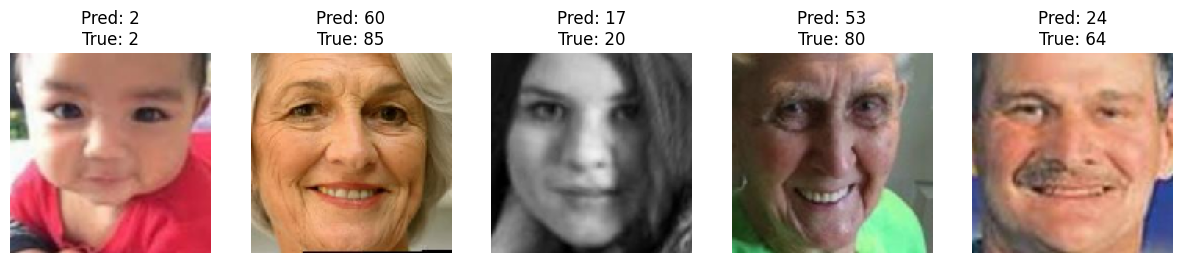

In [20]:
# prompt: test images

import matplotlib.pyplot as plt

# Assuming X_test and y_test are already loaded and the model is trained

# Predict ages for the test set
predicted_ages = model.predict(X_test)

# Function to display images with predicted and actual ages
def display_images_with_predictions(images, predicted_ages, true_ages, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow((images[i] + 1) / 2)  # Adjust if using preprocess_input
        plt.title(f"Pred: {predicted_ages[i][0]:.0f}\nTrue: {true_ages[i]}")
        plt.axis('off')
    plt.show()

# Display some example images with their predictions
display_images_with_predictions(X_test, predicted_ages, y_test)
